# **02443 - Computer Exercise 3: Sampling from Continuous Distributions**

In [2]:
import numpy as np
import pandas as pd

import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp
import plotly.io as pio
pio.templates.default = "plotly_dark"

### **Part 1 - Generating simulated values**

In [3]:
def exp_pdf(x, y=1):
    return y*np.exp(-y*x)

def pareto_pdf(x, k=20, beta=1):
    return k*beta**k / x**(k+1)

def gaussian_pdf(x, mu=0, sigma=1):
    return 1/np.sqrt(2*np.pi)*np.exp(-((x-mu)**2)/(2*sigma**2))

def uniform_2_exponential(U, y=1):
    X = -np.log(U)/y
    return X

def uniform_2_pareto(U, k=20, beta=1):
    X = beta*(U**(-1/k))
    return X

def uniform_2_normal(U):
    n = len(U)
    U1, U2 = U[:int(n/2)], U[int(n/2):]
    theta = 2*np.pi*U2
    r = np.sqrt(-2*np.log(U1))
    Z1, Z2 = r*np.array([np.cos(theta), np.sin(theta)])
    return np.concatenate((Z1, Z2))

In [18]:
U = np.random.rand(10000)

X_exp = uniform_2_exponential(U)
X_pareto = uniform_2_pareto(U)
X_norm = uniform_2_normal(U)

In [19]:
# Plot
fig = sp.make_subplots(rows=1, cols=3, subplot_titles=("Exponential distribution", "Pareto distribution", "Normal distribution"))

x_exp = np.linspace(min(X_exp), max(X_exp), 100, endpoint=True)
fig.add_trace(go.Scatter(x=x_exp, y=exp_pdf(x_exp), mode='lines', name='Exponential PDF', line=dict(color='red')), row=1, col=1)
fig.add_trace(go.Histogram(x=X_exp, xbins=dict(start=0, size=(max(X_exp)-min(X_exp))/20), histnorm='probability density', name='Exponential Histogram', marker=dict(color='orange')), row=1, col=1)

x_pareto = np.linspace(min(X_pareto), max(X_pareto), 100, endpoint=True)
fig.add_trace(go.Scatter(x=x_pareto, y=pareto_pdf(x_pareto), mode='lines', name='Pareto PDF', line=dict(color='red')), row=1, col=2)
fig.add_trace(go.Histogram(x=X_pareto, xbins=dict(start=1, size=(max(X_pareto)-min(X_pareto))/20), histnorm='probability density', name='Pareto Histogram', marker=dict(color='blue')), row=1, col=2)

x_norm = np.linspace(min(X_norm), max(X_norm), 100, endpoint=True)
fig.add_trace(go.Scatter(x=x_norm, y=gaussian_pdf(x_norm), mode='lines', name='Normal PDF', line=dict(color='red')), row=1, col=3)
fig.add_trace(go.Histogram(x=X_norm, xbins=dict(size=(max(X_norm)-min(X_norm))/20), histnorm='probability density', name='Normal Histogram', marker=dict(color='green')), row=1, col=3)

fig.update_layout(height=300, width=1000, showlegend=False, bargap=0.1, margin=dict(l=50, r=50, t=50, b=50))

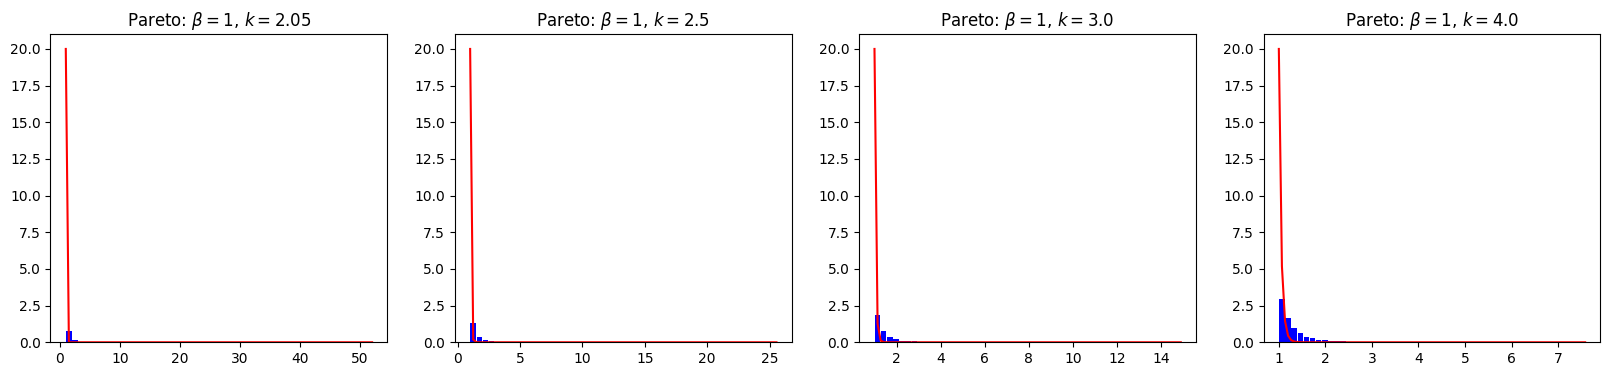

In [20]:
import matplotlib.pyplot as plt
beta = 1
ks = np.array([2.05, 2.5, 3, 4])
U = np.random.rand(10000)

plt.figure(figsize=(20, 4))
for i, k in enumerate(ks):
    plt.subplot(1, 4, i+1)
    X = uniform_2_pareto(U, k, beta)
    x = np.linspace(min(X), max(X), 100, endpoint=True)
    plt.plot(x, pareto_pdf(x), color="Red")
    plt.hist(X, rwidth=0.9, bins=50, color="Blue", density=True)
    plt.title(r"Pareto: $\beta = {}$, $k = {}$".format(beta, k))

plt.show()

### **Part 2 - Comparison of simulation and analytic results for Pareto distribution**

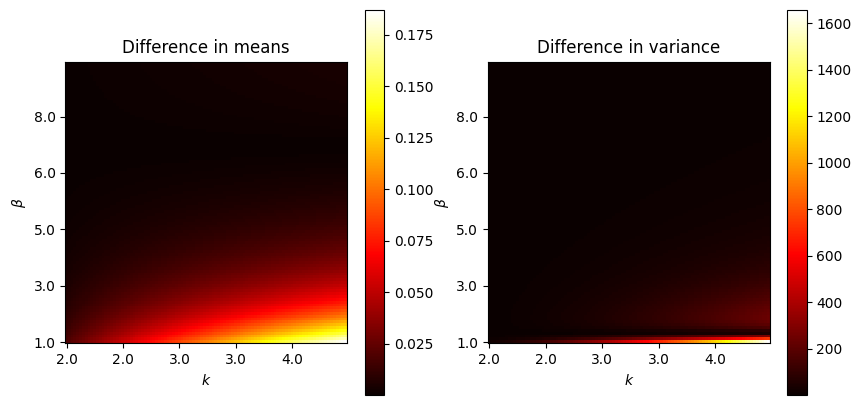

In [7]:
nk = 100
nbeta = 100

ks = np.linspace(2.05, 4, nk)
betas = np.linspace(1, 10, nbeta)

mean_diff = np.zeros((nk, nbeta))
var_diff = np.zeros((nk, nbeta))

U = np.random.rand(10000)

for i, k in enumerate(ks):
    for j, beta in enumerate(betas):
        X = uniform_2_pareto(U, k, beta)
        EX = beta*k/(k-1)
        VarX = beta**2 * k / ((k-1)**2 * (k-2))
        mean_diff[i, j] = abs(np.mean(X) - EX)
        var_diff[i, j] = abs(np.var(X) - VarX)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Difference in means")
plt.imshow(mean_diff, cmap='hot', interpolation='nearest')
plt.xticks(range(nk)[::20], np.round(ks[::20]))
plt.yticks(range(nbeta)[::20], np.round(betas[::20]))
plt.xlabel(r"$k$")
plt.ylabel(r"$\beta$")
plt.gca().invert_yaxis()
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Difference in variance")
plt.imshow(var_diff, cmap='hot', interpolation='nearest')
plt.xticks(range(nk)[::20], np.round(ks[::20]))
plt.yticks(range(nbeta)[::20], np.round(betas[::20]))
plt.xlabel(r"$k$")
plt.ylabel(r"$\beta$")
plt.gca().invert_yaxis()
plt.colorbar()


### **Part 3 - Confidence intervals of normal distribution**

In [8]:
alpha = 0.05
n_samples = 100
N = 10

from scipy.stats import t, chi2

# Preallocate
means = np.zeros(n_samples)
stds = np.zeros(n_samples)
CI_means = np.zeros((n_samples, 2))
CI_vars = np.zeros((n_samples, 2))

# Precompute for speed
t_val = t.ppf(1-alpha/2, N-1)
inv_chi1 = 1/chi2.ppf(1-alpha/2, N-1)
inv_chi2 = 1/chi2.ppf(alpha/2, N-1)
inv_sqrt_N = 1/np.sqrt(N)

for i in range(n_samples):
    # Get 10 uniform random numbers
    U = np.random.rand(N)

    # Generate normally distributed sample
    X = uniform_2_normal(U)

    # Compute sample statistics
    means[i] = X.mean()
    stds[i] = X.std()
    CI_means[i] = means[i] + t_val*stds[i]*inv_sqrt_N*np.array([-1, 1])
    CI_vars[i] = (N-1)*stds[i]**2 * np.array([inv_chi1, inv_chi2])

In [9]:
nor

NameError: name 'nor' is not defined

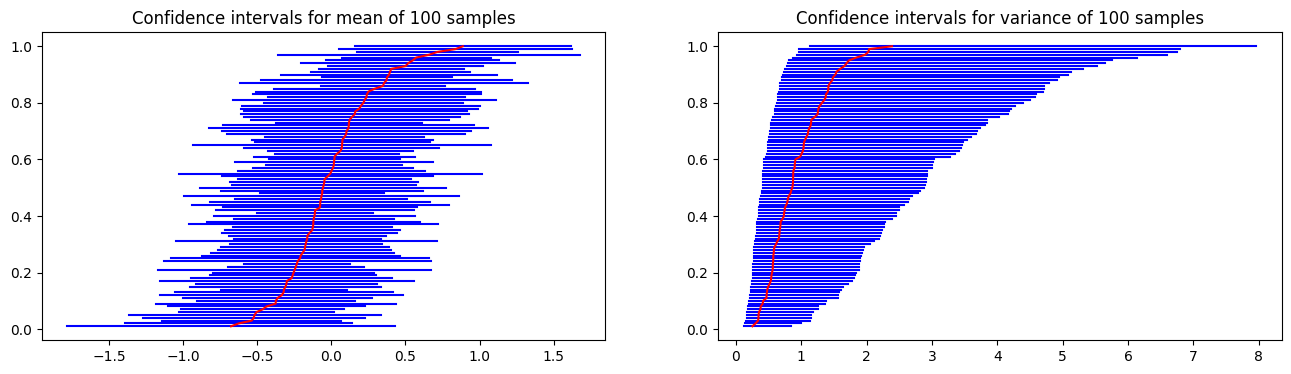

In [ ]:
sort_idx = np.argsort(means)
means = means[sort_idx]
CI_means = CI_means[sort_idx]

sort_idx = np.argsort(stds)
stds = stds[sort_idx]
CI_vars = CI_vars[sort_idx]

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
for i, CI in enumerate(CI_means):
    plt.plot(CI, 2*[(i+1)/n_samples], color="blue")
plt.plot(means, np.linspace(1, n_samples, n_samples, endpoint=True)/n_samples, color="Red")
plt.title("Confidence intervals for mean of 100 samples")

plt.subplot(1, 2, 2)
for i, CI in enumerate(CI_vars):
    plt.plot(CI, 2*[(i+1)/n_samples], color="blue")
plt.plot(stds**2, np.linspace(1, n_samples, n_samples, endpoint=True)/n_samples, color="Red")
plt.title("Confidence intervals for variance of 100 samples")
plt.show()